# Brain Tumor Classification using Deep Learning

In this project, we tackle the task of classifying brain tumors from MRI images using a deep learning model. Brain tumor classification is a challenging yet vital component of diagnostic radiology, aiming to distinguish between different types of brain tumors. Early and accurate diagnosis can significantly impact treatment decisions and patient outcomes. Our goal is to develop a deep learning model that can accurately classify brain tumors, aiding radiologists and healthcare professionals in their diagnosis processes.

## 1 <span style='color:#e61227'>|</span> Setup

### 1.1 <span style='color:#e61227'> |</span> Libraries

First we need to import the required libraries and frameworks.

In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader, Subset, WeightedRandomSampler
from torchvision import datasets, transforms
import timm
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, classification_report
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import numpy as np
import os
import re
import seaborn as sns
import random
from functools import partial
import tempfile
import ray
from ray import train, tune
from ray.train import Checkpoint, RunConfig
from ray.tune.schedulers import PopulationBasedTraining
from ray.tune.tune_config import TuneConfig
from ray.tune.tuner import Tuner
from ray.tune.analysis import ExperimentAnalysis

### 1.2 <span style='color:#e61227'> |</span> GPU

We will also setup our deep learning framework to run on our GPU device (if there is one available). This will immensely speed up the training and testing of our model.

In [2]:
# Check for GPU availability and set the device accordingly.
if torch.cuda.is_available():    
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: NVIDIA GeForce RTX 4060 Laptop GPU


## 2 <span style='color:#e61227'>|</span> Data Preparation

### 2.1 <span style='color:#e61227'> |</span> Preview

The dataset consists of MRI images of brain tumors, categorized into four classes. Let's preview some of them.

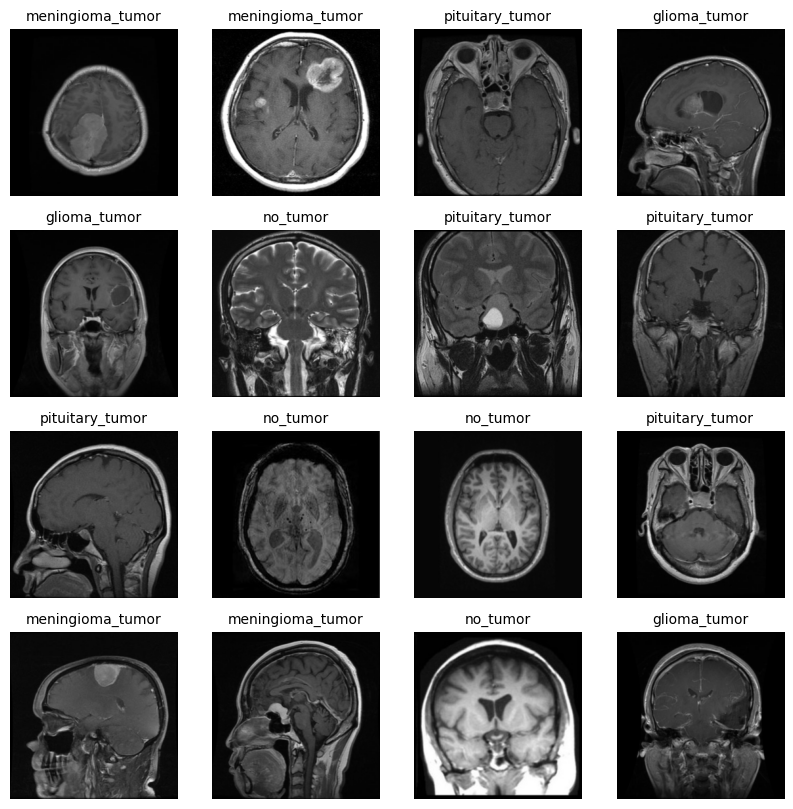

In [3]:
# Set up basic transformations and loading a subset for preview.
plain_transform = transforms.Compose([
    transforms.Resize((256, 256)),  # Resize the images.
    transforms.ToTensor(),  # Convert to tensor.
])
dataset = datasets.ImageFolder(root='dataset/Training', transform=plain_transform)  # Load the dataset.

# Select a subset of images for previewing purposes.
num_classes = 4
subset_size = 16
indices = np.random.choice(len(dataset), subset_size, replace=False)
subset_dataset = Subset(dataset, indices)
preview_loader = DataLoader(subset_dataset, batch_size=subset_size, shuffle=False)

# Display images in a grid to preview the dataset.
images, classes = next(iter(preview_loader))
labels = [dataset.classes[x] for x in classes]
fig, axes = plt.subplots(4, 4, figsize=(10, 10))
for i, (image, label) in enumerate(zip(images, labels)):
    plt.subplot(4, 4, i + 1)
    plt.imshow(np.transpose(image, (1,2,0)))
    plt.title(label, fontsize=10)
    plt.axis('off')
plt.show()

### 2.2 <span style='color:#e61227'> |</span> Pre-processing & Augmentation

Data preparation is a critical step to ensure our model receives input that is consistent with the format and conditions it was trained on, as well as varied enough to allow generalization and accurate predictions on unseen data. We perform several preprocessing steps, including resizing images, converting them to tensor format, and normalization. Additionally, we apply data augmentation techniques like random rotations and shifts to introduce variability in the dataset, simulating potential variations in the real-world imaging.

In [4]:
# Function to calculate mean and standard deviation for normalization.
def calculate_mean_std(loader):
    mean = 0.
    std = 0.
    total_images_count = 0
    for images, _ in loader:
        images = images.view(images.size(0), images.size(1), -1)
        total_images_count += images.size(0)
        mean += images.mean(2).sum(0) 
        std += images.std(2).sum(0)
    mean /= total_images_count
    std /= total_images_count
    return mean, std

# Load the dataset and calculating its mean and std.
dataloader = DataLoader(dataset, batch_size=64)
mean, std = calculate_mean_std(dataloader)

In [5]:
class RandomShiftZoom(transforms.RandomAffine):
    """Custom transform for random shifts and zooms."""
    def __init__(self, shift_range, zoom_range):
        super().__init__(degrees=0, translate=shift_range, scale=(1-zoom_range, 1+zoom_range), fill=0)
    def __call__(self, img):
        if self.translate is not None:
            max_dx = self.translate[0] * img.size[0]
            max_dy = self.translate[1] * img.size[1]
            translations = (random.uniform(-max_dx, max_dx), random.uniform(-max_dy, max_dy))
        else:
            translations = None
        scale = random.uniform(self.scale[0], self.scale[1])
        return transforms.functional.affine(
            img, angle=0, translate=translations, scale=scale, shear=0,
        )

# Set up transformation pipelines for training and validation/testing.
transforms_pipeline = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomRotation(70),
        RandomShiftZoom(shift_range=(0.05, 0.05), zoom_range=0.1),
        transforms.ToTensor(),
        transforms.Normalize(mean=mean, std=std),
    ]),
    'val_test': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=mean, std=std),
    ]),
}

# Load the training and validation datasets.
trainval_dataset = datasets.ImageFolder(root=os.path.abspath('./dataset/Training'))

# Load the test dataset, applying the predefined transformations for validation/testing.
test_dataset = datasets.ImageFolder(
    root=os.path.abspath('./dataset/Testing'), transform=transforms_pipeline['val_test']
)

### 2.3 <span style='color:#e61227'> |</span> Class Distribution

We observe that the test dataset is not balanced across classes. To optimize the training process with respect to achieving the best test accuracy (assuming that the test distribution portrays the distribution of the data in the real world), we make sure the validation dataset follows the same imbalanced distribution.

It is important however that the training dataset is balanced across classes. This is to encourage the model to make classification decisions based on the features of the given data, rather than based on frequency bias. Since the available training dataset is not balanced, we use oversampling to increase the number of samples of the under-represented classes.

In [6]:
# Function to split a dataset into two subsets with a custom distribution.
def stratified_custom_split(dataset, desired_distribution_percentages, smallest_class_percentage):
    # Extract the targets and identify unique classes within the dataset.
    targets = np.array(dataset.targets)
    unique_classes = np.unique(targets)
    num_classes = len(unique_classes)
    
    # Calculate the minimum class size for the second dataset based on the smallest class.
    min_class_size = min(len(np.where(targets == cls)[0]) for cls in unique_classes) * smallest_class_percentage
    total_size_second_dataset = min_class_size * num_classes
    
    # Determine the desired number of instances per class in the second dataset.
    desired_counts_per_class = [int(total_size_second_dataset * pct) for pct in desired_distribution_percentages]

    second_indices = []
    first_indices = []
    for cls in unique_classes:
        class_indices = np.where(targets == cls)[0]
        np.random.shuffle(class_indices)  # Shuffle to ensure random selection.
        
        # Use the desired count for each class or the class size, whichever is smaller, to avoid oversampling.
        class_second_count = min(desired_counts_per_class[int(cls)], len(class_indices))
        
        # Split indices for the current class between the two datasets.
        second_indices.extend(class_indices[:class_second_count])
        first_indices.extend(class_indices[class_second_count:])
    
    # Create and return the two subsets.
    first_subset = Subset(dataset, indices=first_indices)
    second_subset = Subset(dataset, indices=second_indices)
    return first_subset, second_subset


# Function to check the class distribution in a dataset.
def check_class_balance(dataset):
    # Get the dataset targets, also handling cases where dataset is a Subset.
    if hasattr(dataset, 'dataset') and hasattr(dataset, 'indices'):
        # Extract targets for Subset.
        targets = [dataset.dataset.targets[i] for i in dataset.indices]
    else:
        # Directly access targets for a standard Dataset.
        targets = dataset.targets

    # Calculate the number of samples per class and the total number of samples.
    counts = np.bincount(targets)
    total_samples = sum(counts)
    
    # Calculate proportions for each class.
    proportions = [count / total_samples for count in counts]
    
    # Print the class percentages.
    for class_index, proportion in enumerate(proportions):
        print(f'Class {class_index}: {proportion*100:.2f}%')
    
    return proportions

In [7]:
print('Class distribution in the test dataset:')
test_distribution = check_class_balance(test_dataset);

Class distribution in the test dataset:
Class 0: 25.38%
Class 1: 29.19%
Class 2: 26.65%
Class 3: 18.78%


In [8]:
print('Class distribution in the training+validation dataset:')
check_class_balance(trainval_dataset);

Class distribution in the training+validation dataset:
Class 0: 28.78%
Class 1: 28.64%
Class 2: 13.76%
Class 3: 28.82%


In [9]:
# Split to get a validation dataset that mimics the distribution of the test dataset.
train_dataset, val_dataset = stratified_custom_split(trainval_dataset, test_distribution, 0.3)

# Apply the specified transformations to the training and the validation dataset.
train_dataset.dataset.transform = transforms_pipeline['train']
val_dataset.dataset.transform = transforms_pipeline['val_test']

In [10]:
print('Class distribution in the training dataset:')
check_class_balance(train_dataset);

print('\nClass distribution in the validation dataset:')
check_class_balance(val_dataset);

Class distribution in the training dataset:
Class 0: 29.45%
Class 1: 28.54%
Class 2: 11.22%
Class 3: 30.79%

Class distribution in the validation dataset:
Class 0: 25.37%
Class 1: 29.18%
Class 2: 26.64%
Class 3: 18.82%


In [11]:
# Calculate weights for each sample of the training dataset.
targets = trainval_dataset.targets
subset_targets = [targets[i] for i in train_dataset.indices]
class_counts = torch.tensor([subset_targets.count(class_id) for class_id in range(len(trainval_dataset.classes))])
class_weights = 1. / class_counts
weights = torch.tensor([class_weights[label] for label in subset_targets])

# Define the WeightedRandomSampler that will be use to balance the training dataset.
sampler = WeightedRandomSampler(weights, len(weights))

## 3 <span style='color:#e61227'>|</span> Classification

### 3.1 <span style='color:#e61227'> |</span> Model Architecture

We utilize the EfficientNet B3 architecture, renowned for its efficiency and accuracy in image classification tasks, as the backbone of our model. The model is customized with additional layers to tailor it to our specific task of brain tumor classification. 

In [12]:
class CustomEfficientNet(nn.Module):
    """Custom EfficientNet model for brain tumor classification."""
    def __init__(self, num_classes=1000):
        super(CustomEfficientNet, self).__init__()
        # Load a pre-trained EfficientNet model.
        self.efficientnet = timm.create_model('efficientnet_b3', pretrained=True)
        
        # Add additional layers to the model for our specific classification task.
        self.additional_layers = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(), 
            nn.BatchNorm1d(1536),
            nn.Linear(1536, 256),  # Linear layer for feature transformation.
            nn.ReLU(),  # Activation function for non-linearity.
            nn.Dropout(0.3),  # Dropout for regularization.
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256),  # Batch normalization.
            nn.Linear(256, num_classes),  # Final layer for classification.
        )
        
    def forward(self, x):
        x = self.efficientnet.forward_features(x)  # Extract the features from EfficientNet.
        return self.additional_layers(x)  # Pass the features through the additional layers.

### 3.2 <span style='color:#e61227'> |</span> Training

The training process involves optimizing the model's parameters to minimize the classification loss, using the Adam optimizer. We also employ Ray Tune for hyperparameter tuning, optimizing our model's performance through the Population-Based Training (PBT) method.

In [13]:
# Function to load the model and optimizer states from a checkpoint.
def load_checkpoint(config, model, optimizer, step):
    checkpoint = train.get_checkpoint()  # Get the latest checkpoint.
    if checkpoint:
        with checkpoint.as_directory() as checkpoint_dir:
            checkpoint_dict = torch.load(os.path.join(checkpoint_dir, "checkpoint.pt"))

        model.load_state_dict(checkpoint_dict["model_state_dict"])  # Load model state.
        optimizer.load_state_dict(checkpoint_dict["optimizer_state_dict"])  # Load optimizer state.
        for param_group in optimizer.param_groups:
            if "lr" in config:  # Update learning rate if specified.
                param_group["lr"] = config["lr"]

        last_step = checkpoint_dict["step"]
        step = last_step + 1
    return model, optimizer, step


# Function to report the training metrics and checkpoints to Ray Tune.
def tune_report(step, config, model, optimizer, metrics):
    if step % config["checkpoint_interval"] == 0:  # Check if it's time to save a checkpoint.
        with tempfile.TemporaryDirectory() as tmpdir:
            torch.save(
                {
                    "step": step,
                    "model_state_dict": model.state_dict(),
                    "optimizer_state_dict": optimizer.state_dict(),
                },
                os.path.join(tmpdir, "checkpoint.pt"),
            )
            train.report(metrics, checkpoint=Checkpoint.from_directory(tmpdir))
    else:
        train.report(metrics)


# Function to run one epoch of training and return the average loss.
def train_epoch(model, train_dataloader, optimizer, criterion):
    model.train()  # Set model to training mode.
    tr_loss = 0
    num_train_samples = 0
    for batch in train_dataloader:
        images, labels = batch[0].to(device), batch[1].to(device)  # Load batch to the device.
        optimizer.zero_grad()  # Reset gradients.
        outputs = model(images)  # Forward pass.
        loss = criterion(outputs, labels)  # Compute loss.
        tr_loss += loss.item()  # Accumulate loss.
        num_train_samples += labels.size(0)  # Count samples processed.
        loss.backward()  # Backward pass.
        optimizer.step()  # Update weights.
    return tr_loss/num_train_samples  # Return average loss.


# Function to run one epoch of validation and return the average loss.
def val_epoch(model, valid_dataloader, criterion):
    model.eval()  # Set model to evaluation mode.
    val_loss = 0
    num_val_samples = 0
    with torch.no_grad():  # Disable gradient computation.
        for batch in valid_dataloader:
            images, labels = batch[0].to(device), batch[1].to(device)  # Load batch to the device.
            outputs = model(images)  # Forward pass.
            loss = criterion(outputs, labels)  # Compute loss.
            val_loss += loss.item()  # Accumulate loss.
            num_val_samples += labels.size(0)  # Count samples processed.
    return val_loss/num_val_samples  # Return average loss.


# Function to be called by Ray Tune that contains the training loop.
def train_func(config, train_dataset, val_dataset):
    # Model, loss criterion, and optimizer instantiation.
    model = CustomEfficientNet(num_classes=num_classes).to(device)
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=config['lr'])
        
    # Prepare the data loaders.
    batch_size = config['batch_size']
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, sampler=sampler)
    valid_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

    step = 1
    model, optimizer, step = load_checkpoint(config, model, optimizer, step)
    while True:  # Training loop.
        train_loss = train_epoch(model, train_dataloader, optimizer, criterion)  # Train for one epoch.
        val_loss = val_epoch(model, valid_dataloader, criterion)  # Validate for one epoch.
        tune_report(step, config, model, optimizer, {"val_loss": val_loss})  # Report metrics.
        step += 1

In [14]:
# Function to setup and start the hyperparameter tuning process.
def tune_model(training_dataset, validation_dataset):
    if ray.is_initialized():
        ray.shutdown()
    resources = {"cpu": 8, "gpu": 1}
    ray.init(resources=resources)

    # Define the search space for the hyperparameters.
    param_space = {
        'batch_size': tune.grid_search([32, 64]),
        "lr": tune.grid_search([1e-3, 1e-5]),
        "checkpoint_interval": 2,
    }
    mutate_config = {
        "lr": tune.qloguniform(lower=1e-6, upper=1e-3, q=1e-6),
    }

    # Set up the Population Based Training scheduler.
    perturbation_interval = 2
    pbt_scheduler = PopulationBasedTraining(
        time_attr="training_iteration",
        perturbation_interval=perturbation_interval,
        hyperparam_mutations=mutate_config,
        synch=True,
    )

    # Configure and start running the tuner.
    tuner = Tuner(
        tune.with_resources(
            partial(
                train_func, 
                train_dataset=training_dataset, 
                val_dataset=validation_dataset,
            ),
            resources=resources,
        ),
        param_space=param_space,
        tune_config=TuneConfig(
            num_samples=1,
            metric="val_loss",
            mode="min",
            scheduler=pbt_scheduler,
        ),
        run_config=RunConfig(
            stop={"training_iteration": 15},
        ),
    )
    return tuner.fit()


# Function to extract the results directory of the experiment given the path of a specific trial.
def get_ray_results_path(input_string):
    # Adjusted regular expression to match up to the first date.
    pattern = r'(.*?\d{4}-\d{2}-\d{2}_\d{2}-\d{2}-\d{2})'
    
    # Attempt to find a match in the input string.
    match = re.match(pattern, input_string)
    
    # If a match is found, return the matched part, otherwise return None.
    return match.group(0) if match else None


# Function to save the best model of the tuning process.
def save_best_model(results_grid, best_last=False):
    # Retrieve the best training instance based on minimum validation loss.
    if best_last:    # Look at the last iteration.
        best_result = results_grid.get_best_result("val_loss", "min")
    else:    # Look at all iterations.
        best_result = results_grid.get_best_result("val_loss", "min", "all")
    best_config = best_result.config  # The configuration of the best trial.
    
    filtered_best_config = {
        key: value for key, value in best_config.items() 
        if 'checkpoint' not in key
    }  # Print only the config params that were tuned.
    print(f"Best trial config: {filtered_best_config}")
    print(f"Best trial final validation loss: {best_result.metrics['val_loss']}")

    # Locate the best checkpoint.
    best_checkpoint_path = best_result.checkpoint.path
    
    # Initialize a model object.
    best_model = CustomEfficientNet(num_classes=num_classes).to(device)
    
    # Load the best checkpoint.
    best_checkpoint = torch.load(os.path.join(best_checkpoint_path, 'checkpoint.pt'))
    best_model.load_state_dict(best_checkpoint['model_state_dict'])
    
    # Save the best model for future use.
    torch.save(best_model, f'best_model.pt')


# Function to visualize the results of the tuning process.
def plot_trials(results_grid, analysis):
    
    # Look up the values each hyperparameter took during each trial.
    trial_labels = []
    for i, trial in enumerate(sorted(analysis.trial_dataframes)):
        df = analysis.trial_dataframes[trial]
        lr_progress, batch_progress = [
            ' \u2192 '.join(df[f'config/{param}'].drop_duplicates().round(10).astype(str)) 
            for param in ['lr', 'batch_size']
        ]
        trial_labels += [f'trial {i} - lr: {lr_progress}, batch_size: {batch_progress}']

    # Visualize the validation loss across all trials.
    plt.figure(figsize=(10,6))
    for i, result in enumerate(results_grid):
        result_df = result.metrics_dataframe  # DataFrame of the trial's metrics.
        plt.plot(
            result_df["val_loss"], 
            label = trial_labels[i],
        ) 
    plt.yscale('log')  # Use logarithmic scale for better visibility of changes.
    ax = plt.gca()
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))  # Set the x-axis to show only integer values.
    plt.xlabel("Training Iterations")
    plt.ylabel("Validation Loss")
    plt.legend()
    plt.tight_layout()
    plt.show()

In [ ]:
# Initiate the hyperparameter tuning process with the training and validation datasets.
results_grid = tune_model(train_dataset, val_dataset)

Best trial config: lr=2e-06, batch_size=64
Best trial validation loss: 0.0014117538818723303


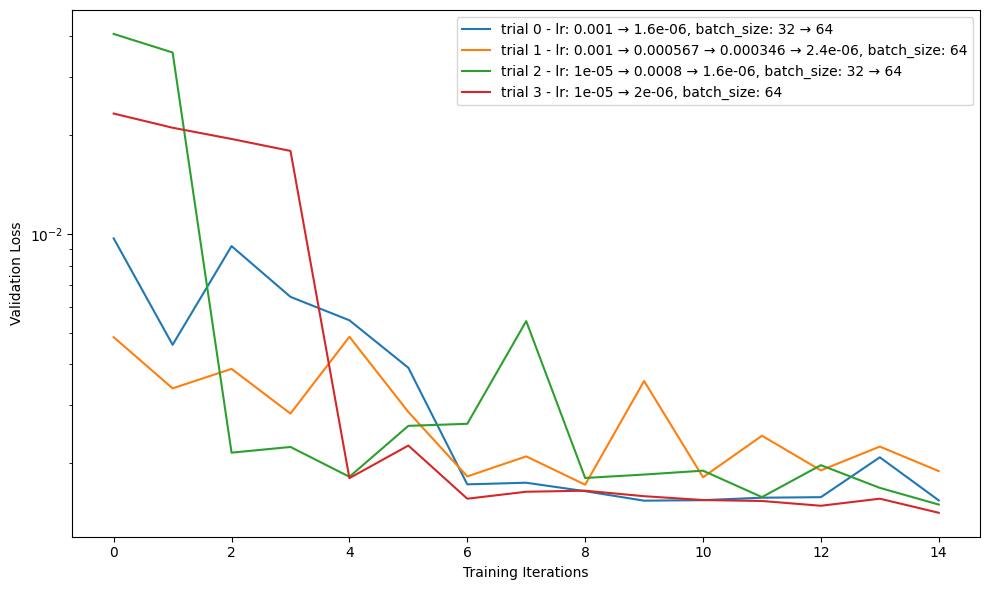

In [16]:
# Locate the results directory.
results_dir = get_ray_results_path(results_grid[0].path)

# Instantiate the ExperimentAnalysis object with the specified results directory.
analysis = ExperimentAnalysis(experiment_checkpoint_path=results_dir)

# Save the best-performing model.
save_best_model(results_grid)

# Display the tuning results.
plot_trials(results_grid, analysis)

### 3.3 <span style='color:#e61227'> |</span> Evaluation

The final step in our project is to evaluate the trained model's performance on a separate test dataset. This step is crucial to assess the model's ability to generalize to new data. We use a variety of metrics, including accuracy, F1 score, and a confusion matrix, to thoroughly evaluate the model's performance across all tumor classes.

In [17]:
# Function to test the model on a test dataset.
def test(model, test_loader):
    true_labels, pred_labels = [], []  # Lists to store true and predicted labels.
    model.to(device)
    model.eval()  # Set model to evaluation mode.
    for batch in test_loader:
        images, labels = batch[0].to(device), batch[1].to(device)  # Load batch to device.
        true_labels.extend(labels.tolist())  # Append true labels.
        with torch.no_grad():  # Disable gradient computation.
            outputs = model(images)  # Forward pass.
            _, predicted_labels = torch.max(outputs.data, dim=1)  # Get the predicted labels.
            pred_labels.extend(predicted_labels.tolist())

    # Compute the confusion matrix and display it.
    matrix = confusion_matrix(true_labels, pred_labels)
    plt.figure(figsize=(8, 6))
    sns.heatmap(matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()
    
    # Calculate and print accuracy and F1 scores.
    accuracy = accuracy_score(true_labels, pred_labels)
    print(f'Accuracy: {accuracy}\n')
    f1_micro = f1_score(true_labels, pred_labels, average='micro')
    print(f'F1 Score (Micro): {f1_micro}\n')
    f1_macro = f1_score(true_labels, pred_labels, average='macro')
    print(f'F1 Score (Macro): {f1_macro}\n')
    
    # Print classification report for detailed analysis.
    report = classification_report(true_labels, pred_labels)
    print(f'Classification Report:\n{report}')

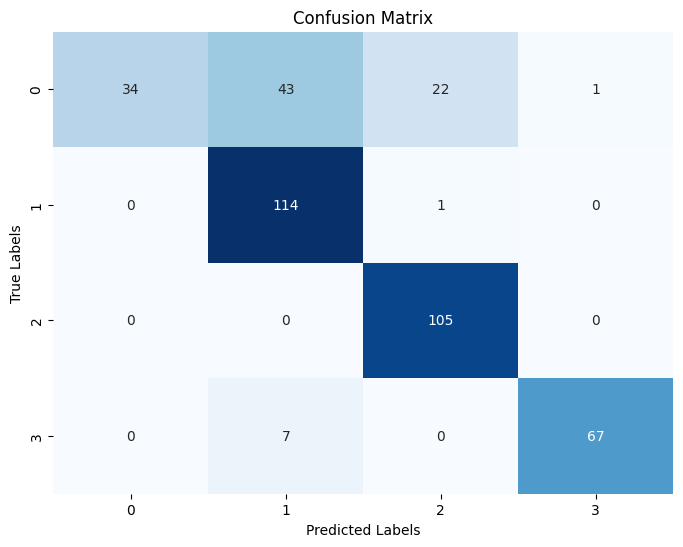

Accuracy: 0.8121827411167513

F1 Score (Micro): 0.8121827411167513

F1 Score (Macro): 0.792404128280372

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.34      0.51       100
           1       0.70      0.99      0.82       115
           2       0.82      1.00      0.90       105
           3       0.99      0.91      0.94        74

    accuracy                           0.81       394
   macro avg       0.88      0.81      0.79       394
weighted avg       0.86      0.81      0.78       394



In [18]:
# Initialize the DataLoader for the test dataset.
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=True)

# Load the best performing model saved during the hyperparameter tuning phase.
best_model = torch.load('best_model.pt')

# Evaluate the loaded model on the test dataset.
test(best_model, test_loader)

The confusion matrix and classification report for this model show an accuracy of approximately 81.2%, which is reasonable but indicates that there might be significant misclassification, particularly for certain classes.

Examining the precision and recall values:
- **Class 0** has a precision of 1.00, which means that every instance predicted as class 0 was correct. However, despite being well-represented in the training set due to oversampling, the model's recall for class 0 is low (0.34), suggesting that the model missed a significant number of actual class 0 instances. This could be because the features that characterise class 0 may not be well captured, or oversampling might have introduced too much noise or artificial variance.
- **Class 1** shows strong performance with a precision of 0.70 and a recall of 0.99, indicating that the model is very good at identifying this class, with the risk of some false positives.
- **Class 2** has perfect precision and a recall of 0.90, making it the best-predicted class, despite it having a significantly lower representation in the original training set. It appears that the oversampling strategy worked well for class 2, perhaps because the features of this class are distinct and less prone to being confused with other classes.
- **Class 3** also performs well with a precision of 0.99 and a recall of 0.91. This suggests that the model has learned to identify its features accurately, even though it was undersampled in the training set relative to its representation in the test set.

To improve the model, we could consider the following actions:
1. **Examining Class 0 Samples**: Looking at the false negatives for class 0 specifically. There might be a pattern or common feature in the misclassified images that the model is not capturing.
2. **Class-specific Adjustments**: For classes with lower performance, we might want to fine-tune the model with a higher weight on those classes or consider using class-weighted or focal loss to penalise the misclassification of underperforming classes more heavily.
3. **Balanced Batches**: Ensuring that each batch of training data has a balanced number of samples from each class to prevent the model from biasing its predictions toward a particular class.
4. **Advanced Oversampling Techniques**: Using techniques like GANs to generate additional training samples for the underrepresented classes.
5. **Explainability**: Using tools like Grad-CAM to visualise where the model is focusing its attention. This can provide insights into whether the model is learning to recognise relevant features for tumour classification.
6.  **Segmentation as a Pre-Step**: Sometimes, using a segmentation model to first identify the region of interest within the brain scan can help the classification model focus on the relevant part of the image.